In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import warnings
import h5py
import pandas as pd
import scipy.interpolate as scintrp
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import savgol_filter as smooth

import windOF as foam
import windPlotting as wPlt
import wind

import winsound

In [3]:
def convertDFSR_out_toNPY(inflDir, sampleName, overwrite=False):
    file_time = inflDir+sampleName+'/time.npy'
    file_probes = inflDir+sampleName+'/probes.npy'
    file_UofT = inflDir+sampleName+'/UofT.npy'
    file_VofT = inflDir+sampleName+'/VofT.npy'
    file_WofT = inflDir+sampleName+'/WofT.npy'
    allFilesExist = os.path.isfile(file_time) and os.path.isfile(file_probes) and os.path.isfile(file_UofT) and os.path.isfile(file_VofT) and os.path.isfile(file_WofT)
    print(f'Case: {sampleName} ...')
    if allFilesExist and not overwrite:
        print(f'\tAll files exist. Skipping conversion from DFSR samples to NPY files.\n')
        return
    
    probes, time, UofT = foam.read_OF_probe_single(inflDir+sampleName+'/Ux','p')
    print('\tFinished reading UofT')
    _, _, VofT = foam.read_OF_probe_single(inflDir+sampleName+'/Uy','p')
    print('\tFinished reading VofT')
    _, _, WofT = foam.read_OF_probe_single(inflDir+sampleName+'/Uz','p')
    print('\tFinished reading WofT')

    UofT = np.transpose(UofT)
    VofT = np.transpose(VofT)
    WofT = np.transpose(WofT)
    print(f"\tShapes: \tUofT: {UofT.shape}, \tVofT: {VofT.shape}, \tWofT: {WofT.shape}")

    if UofT.shape[-1] != VofT.shape[-1] or UofT.shape[-1] != WofT.shape[-1]:
        print('\tShapes of UofT, VofT, WofT are not the same. Trimming the longer ones.')
        minLen = np.min([UofT.shape[-1], VofT.shape[-1], WofT.shape[-1]])
        UofT = UofT[:,:minLen]
        VofT = VofT[:,:minLen]
        WofT = WofT[:,:minLen]

    np.save(file_time,time)
    np.save(file_probes,probes)
    np.save(file_UofT,UofT)
    np.save(file_VofT,VofT)
    np.save(file_WofT,WofT)
    print(f'\tFinished saving to NPY files.\n')

    winsound.Beep(1000, 1000)

def saveFoamCaseTH_toFile(caseDir, probeName, H,):
    les_x0 = foam.processVelProfile(caseDir,probeName=probeName,name="___",exportPlots=False, trimTimeSegs=[[0,1.0]],H=H, showLog=False)
    np.save(caseDir+probeName+'_time.npy',les_x0.t)
    np.save(caseDir+probeName+'_Z.npy',les_x0.Z)
    np.save(caseDir+probeName+'_UofT.npy',les_x0.UofT)
    np.save(caseDir+probeName+'_VofT.npy',les_x0.VofT)
    np.save(caseDir+probeName+'_WofT.npy',les_x0.WofT)



In [4]:
raw_wtFile_fine = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Fr1_forPython.mat"
raw_wtFile_med2 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr2_forPython.mat"
raw_wtFile_med3 = r"D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/BLWT_tests/2022_08_TTU_WL_BLWT/Data/Profiles/ProcessedData/tngE2Mr3_forPython.mat"
dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"

inflowDir_E2 = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

lScl=0.02
H = 0.08


# Load the target wind field

The current profile data has already been scaled in Matlab. The cobra probe $U_h$ was around 7 $m/s$.

In [5]:
Uh_HFPI = 12.5
Uh_cobra = 7.6
vel_ratio = Uh_HFPI/Uh_cobra

data = h5py.File(raw_wtFile_fine, 'r')
print(data.keys())
Z = data['Z'][0]
U_TH = np.array(data['UofT']).copy()*vel_ratio
V_TH = np.array(data['VofT']).copy()*vel_ratio
W_TH = np.array(data['WofT']).copy()*vel_ratio
dt = data['dt'][0][0]/vel_ratio
wtVel_E2 = wind.profile(name="BLWT-E2 (F)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32)
del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med2, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M2 = wind.profile(name="BLWT-E2 (M2)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

# data = h5py.File(raw_wtFile_med3, 'r')
# print(data.keys())
# Z = data['Z'][0]
# U_TH = np.array(data['UofT']).copy()
# V_TH = np.array(data['VofT']).copy()
# W_TH = np.array(data['WofT']).copy()
# dt = data['dt'][0][0]
# wtVel_M3 = wind.profile(name="BLWT-E2 (M3)", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=16)
# del U_TH, V_TH, W_TH

esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))

wt_vs_ESDU = wind.Profiles([wtVel_E2, esdu74_E2.toProfileObj(n=np.logspace(-2.5,1.5,100)), esdu85_E2.toProfileObj(n=np.logspace(-2.5,1.5,100))],)


<KeysViewHDF5 ['H', 'README', 'UofT', 'VofT', 'WofT', 'Z', 'dt', 'exposureName']>


## Trial 1
- Basic trial
- Scaling is applied based on ratio over the entire profile

In [6]:
infl_E2_trial1 = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
# infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
# infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r2')
# infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r2', name='DFSR.r2')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r2.s2')
# infl_E2_trial1.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r2.s2', name='DFSR.r2.s2')

# # infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v0/', probeName='prof_x0_y0', name='tngE2.ed.v0', readFromNPY_file=True, writeToDataFile=True)
# infl_E2_trial1.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v1/', probeName='prof_x0_y0', name='tngE2.ed.v1', readFromNPY_file=True, writeToDataFile=True)
# infl_E2_trial1.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v1.m2/', probeName='prof_x0_y0', name='tngE2.ed.v1.m2', readFromNPY_file=True, writeToDataFile=True)
# # infl_E2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v2/', probeName='prof_x0_y0', name='tngE2.ed.v2', readFromNPY_file=True, writeToDataFile=True)


n=np.logspace(-3.5,1.5,100)
infl_E2_trial1.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), wind.ESDU85(z0=0.02).toProfileObj(n=n), ])

## Trial 2
Changes:
- Fixed the scaling ratio to a fixed value corresponding to the reference height for the second round. 


In [7]:
infl_E2_trial2 = foam.inflowTuner(H=H, nSpectAvg=32,
                                target=wtVel_E2,)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
# infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v1')
# infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v1', name='DFSR.fr.r1 (bad_W)')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v2')
# infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v2', name='DFSR.fr.r2')

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'tngE2.fr.v3')
# infl_E2_trial2.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='tngE2.fr.v3', name='DFSR.fr.r3')

# infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.v0/', probeName='prof_x0_y0', name='tngE2.ed.v0', readFromNPY_file=True, writeToDataFile=True,
#                        kwargs_profile={'nSpectAvg':32})
# infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v1.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v1.m2', readFromNPY_file=True, writeToDataFile=True,
#                        kwargs_profile={'nSpectAvg':32})
# infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v2.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v2.m2', readFromNPY_file=True, writeToDataFile=True, 
#                        kwargs_profile={'nSpectAvg':32})
# infl_E2_trial2.addIncident(caseDir=inflowDir_E2+'ED/tngE2.ed.fr.v3.m2/', probeName='prof_x0_y0', name='tngE2.ed.fr.v3.m2', readFromNPY_file=False, writeToDataFile=True)


n=np.logspace(-3.5,2.5,100)
infl_E2_trial2.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), wind.ESDU85(z0=0.02).toProfileObj(n=n), ])

### Trial 2: scale & export

In [8]:
rnd = 3
caseName = f'tngE2.fr.v{rnd}'
prof = infl_E2_trial2.writeProfile(
                            # dir=inflowDir_E2 + f'tuning/infl.r{rnd}/', 
                            # dir=inflowDir_E2 + f'tuning/{caseName}/', 
                            caseName=caseName,
                            rounds=rnd,
                            zLim=[0,15],
                            debugMode=True,
                            applySmoothing=True,
                            applyLimitedSmoothing=False,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.08,
                            zMax_scaling=0.08*7,
                                          # round:      [0,     1,      2,      3,      4, 5, 6]
                            scaleByFixedRefHeightRatio= [True,  False,  True,   True,],
                            scale_xLi=                  [True,  False,  False,  False,],
                            smoothWindow=[50, 50, 50, 50, 200, 150, 200],
                            figsize=[15,15])


TypeError: writeProfile() got an unexpected keyword argument 'applySmoothing'

## Trial 3
Changes:
- Quick test comparison between the baseline `infl.r0` and `infl.r0.n25m4096` showed that increasing `nFreq` improved the integral length scale. 
- It also had an impact on the turbulence intensity and spectra.
- The effect of `nInterp` was also tested, but it didn't have as much impact.
- In these sets, `nFreq` is increased from 1024 to 4096 and `nInterp` is kept as the default 25.
- This lets us avoid the need to scale the integral length scale.


In [12]:
infl_E2_trial3 = foam.inflowTuner(H=H, nSpectAvg=16, target=wtVel_E2, lScl=1/50)

trial_dir_in = inflowDir_E2+'tuning.trial3/'

name = 'infl.t3.r0'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

name = 'infl.t3.r1'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

name = 'infl.t3.r2a'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

# name = 'infl.t3.r1.1'
# convertDFSR_out_toNPY(trial_dir_in, name)
# infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

# name = 'infl.t3.r2'
# convertDFSR_out_toNPY(trial_dir_in, name)
# infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

name = 'infl.t3.r7a.1'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_E2_trial3.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

trial_dir_ed = inflowDir_E2+'ED.trial3/'

# name = 'tngE2.ed.t3.r0'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r1'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r2a'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32},
#                            trimTimeSegs=[[0,1],[1.846,1.85]])

# name = 'tngE2.ed.t3.r3a'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r4a'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r5b'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r6b'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

name = 'tngE2.ed.t3.r6a'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

name = 'tngE2.ed.t3.r7a'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

name = 'tngE2.ed.t3.r7a.1'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32},
                           trimTimeSegs=[[0, 1],[3.052, 10.1], [25, 100]],
                           kwargs_readVelProfile={'readPressure':False})

name = 'tngE2.ed.t3.r7a.2'
infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32},
                           kwargs_readVelProfile={'readPressure':False})



# name = 'tngE2.ed.t3.r1.1'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=False, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t3.r2'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# casedir = r'D:/tempData_depot/simData_CandC/wt_tngE2/'

# name = 'tngE2.1'
# infl_E2_trial3.addIncident(caseDir=casedir+name, probeName='sampler.zProfile_x0y0.probes', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':16})

# name = 'tngE2.2.2'
# infl_E2_trial3.addIncident(caseDir=casedir+name, probeName='sampler.zProfile_x0y0.probes', name=name, readFromNPY_file=False, writeToDataFile=True, kwargs_profile={'nSpectAvg':16})


# name = 'tngE2.ed.t3.r0'
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x-0.3_y0', name=name+'(-0.3)', readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x-0.2_y0', name=name+'(-0.2)', readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name+'(0.0)', readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})
# infl_E2_trial3.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0.8_y0', name=name+'(0.8)', readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

n=np.logspace(-3.5,2.5,100)

vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E2.SpectH
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

infl_E2_trial3.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01, Zref=H/lScl).toProfileObj(n=n), wind.ESDU85(z0=0.01, Zref=H/lScl).toProfileObj(n=n), vonk])
# infl_E2_trial3.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), vonk])

Case: infl.t3.r0 ...
	All files exist. Skipping conversion from DFSR samples to NPY files.

Case: infl.t3.r1 ...
	All files exist. Skipping conversion from DFSR samples to NPY files.

Case: infl.t3.r2a ...
	All files exist. Skipping conversion from DFSR samples to NPY files.

Case: infl.t3.r7a.1 ...
	All files exist. Skipping conversion from DFSR samples to NPY files.

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r6a
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r6a/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/ED.trial3//tngE2.ed.t3.r7a
Probe read from:		D:/tempData_depot/simData_

In [ ]:
infl_E2_trial3.incidents[-1].T


40.506

In [ ]:
vonk = wind.profile(name='vonK', )
Sp = wtVel_E2.SpectH.copy()
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

vonk2 = wind.profile(name='vonK_L', )
Sp2 = wtVel_E2.SpectH.copy()
Suu2, Svv2, Sww2 = wind.vonKarmanSpectra(n=n, U=Sp2.U, Iu=Sp2.Iu, Iv=Sp2.Iv, Iw=Sp2.Iw, xLu=Sp2.xLu*1.5, xLv=Sp2.xLv*1.5, xLw=Sp2.xLw*1.5,)
vonk2.SpectH = wind.spectra(name=vonk2.name, Z=H, Suu=Suu2, Svv=Svv2, Sww=Sww2, n=n, U=Sp2.U, Iu=Sp2.Iu*1.2, Iv=Sp2.Iv, Iw=Sp2.Iw, xLu=Sp2.xLu*1.5, xLv=Sp2.xLv*1.5, xLw=Sp2.xLw*1.5,)

vonk3 = wind.profile(name='vonK_I', )
Sp3 = wtVel_E2.SpectH.copy()
Suu3, Svv3, Sww3 = wind.vonKarmanSpectra(n=n, U=Sp3.U, Iu=Sp3.Iu*1.5, Iv=Sp3.Iv*1.5, Iw=Sp3.Iw*1.5, xLu=Sp3.xLu, xLv=Sp3.xLv, xLw=Sp3.xLw,)
vonk3.SpectH = wind.spectra(name=vonk3.name, Z=H, Suu=Suu3, Svv=Svv3, Sww=Sww3, n=n, U=Sp3.U, Iu=Sp3.Iu*1.5, Iv=Sp3.Iv*1.5, Iw=Sp3.Iw*1.5, xLu=Sp3.xLu, xLv=Sp3.xLv, xLw=Sp3.xLw,)

pprofs = wind.Profiles([vonk, vonk2, vonk3])
_ = pprofs.plotSpect(figsize=[20,6])


### Trial 3: scale & export

Case name					: infl.t3.r7a
Description					: Round 6a: Follows Round-5a. The integral length scale is not scaled throughout the previous rounds. This is the first round where the Empty Domain size is increased to accomodate the xLu.
Date						: 2023-08-11 16:01:29.551357
Scaling rounds				: 7
Scale by fixed Zref ratio	: [False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False]
Scale xLi					: [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
Compensate for xLi in Ii	: False
Smooth the target			: True
Smooth ratios				: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Smooth window (ratios) 		: [60, 100, 100, 100, 200, 150, 200]
Smooth window (target) 		: [80, 50, 50, 50, 200, 150, 200]
Apply limited smoothing		: False
Smoothing kwargs			: {'window': 'hamming', 'mode': 'valid', 'usePadding': True, 'paddingFactor': 2, 'paddi

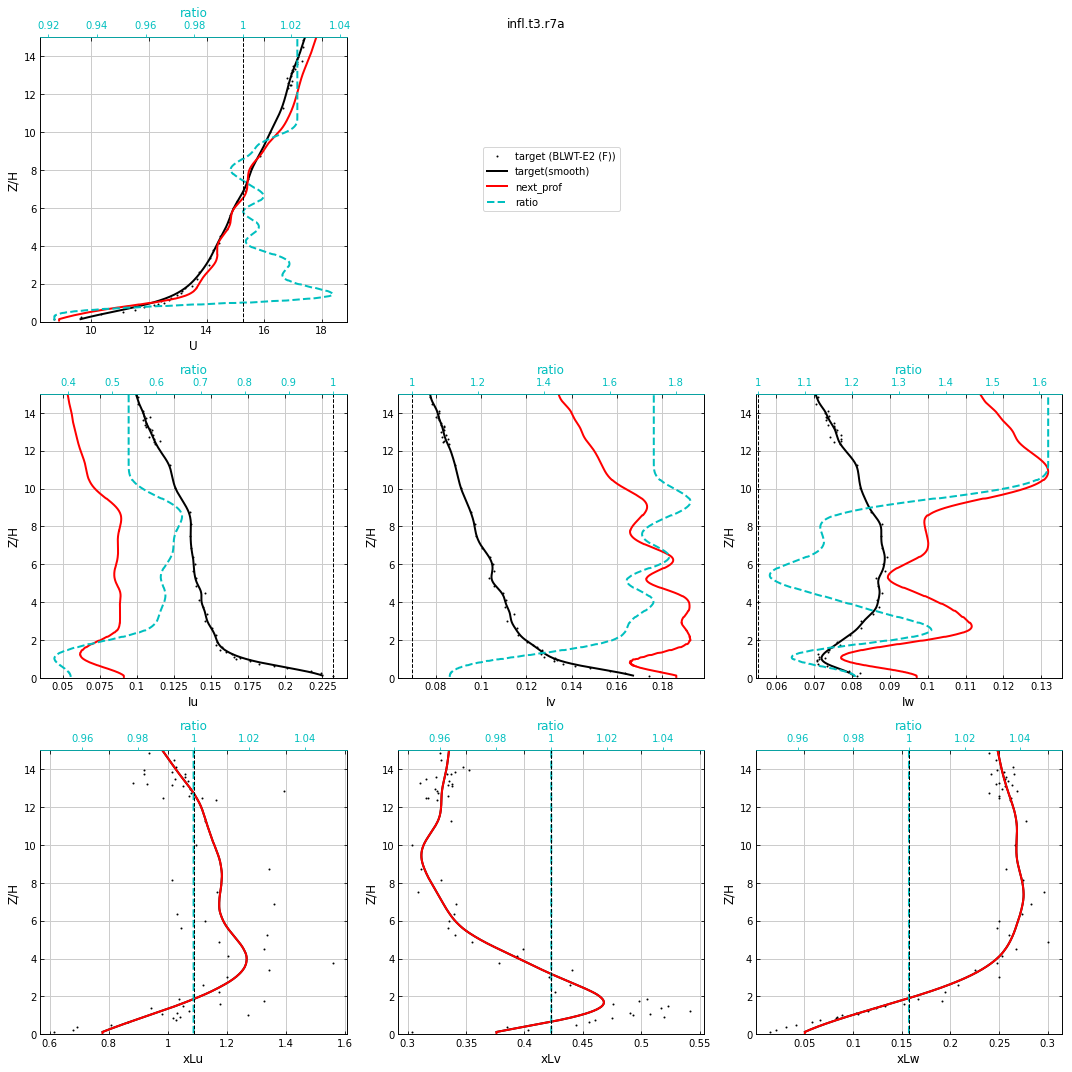

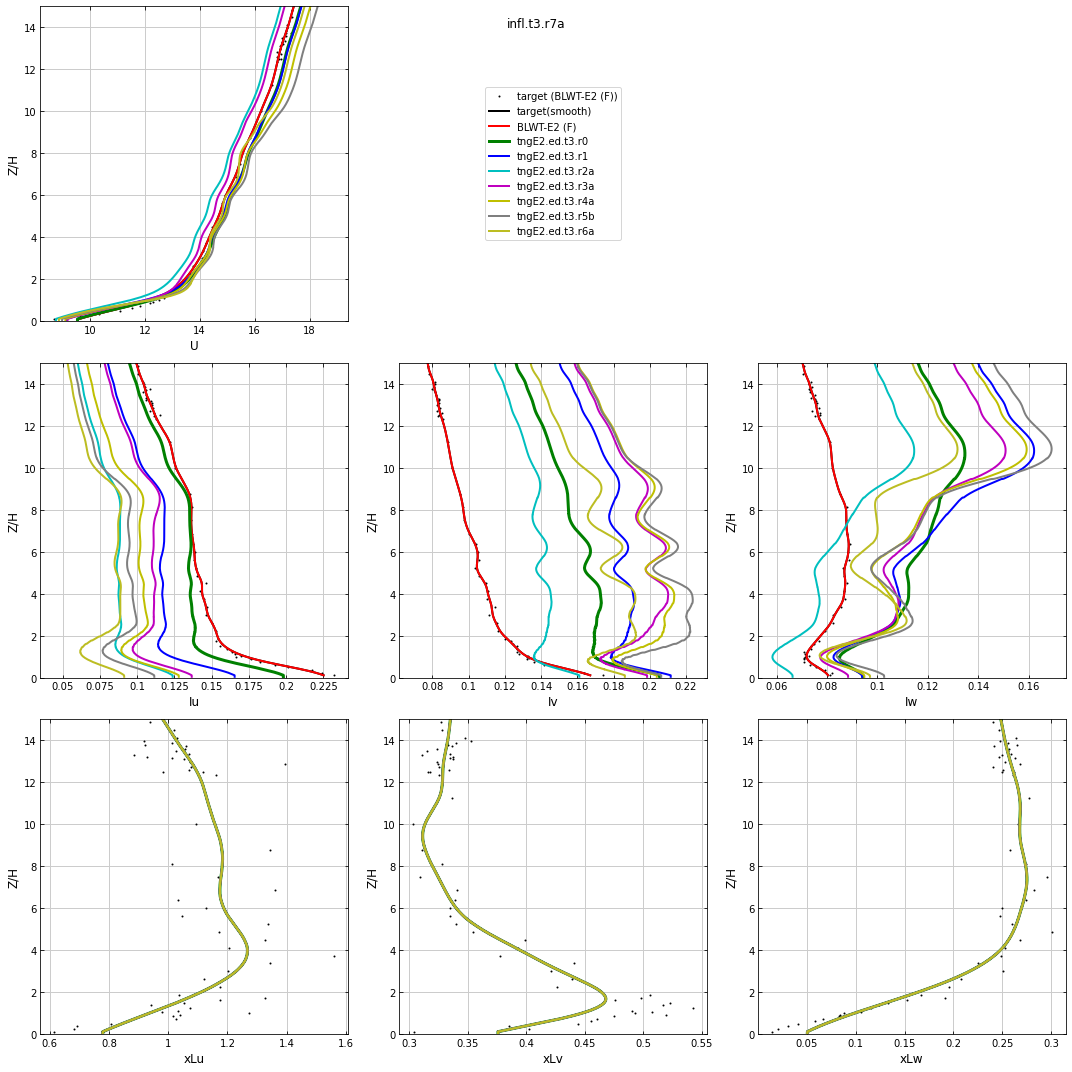

In [ ]:
rnd = 7
caseName = f'infl.t3.r{rnd}a'
prof = infl_E2_trial3.writeProfile(
                            dir=trial_dir_in + f'/{caseName}/',
                            caseName=caseName,
                            # description='Round 0: Original target (round 0) with increased nFreq = 8192 (verify this from DFSR log). That should avoid the need for scaling the integral length scale. The Iu is expected to be higher than the target which will be scaled down in the next round.',
                            # description='Round 1: First round with increased nFreq = 8192 (verify this from DFSR log). Scaled by variable ratio along the profile.',
                            # description='Round 2: Applied variable ratio along the profiles for all seven. The integral length scale is also scaled, but not compensated in the TI.',
                            # description='Round 2a: The earlier Round-2 is reverted to avoid the integral length scaling and to only improve the TI.',
                            # description='Round 3a: Follows Round-2a, after the update of the scaling function.',
                            # description='Round 4a: Follows Round-3a.',
                            # description="Round 5a: Follows Round-4a. The integral length scale is not scaled ('a' series do not scale integral scale).",
                            # description='Round 5b: Follows Round-4a. The integral length scale is scaled, but not compensated in the TI.',
                            # description='Round 6b: Follows Round-5b. The integral length scale is not scaled.',
                            description='Round 6a: Follows Round-5a. The integral length scale is not scaled throughout the previous rounds. This is the first round where the Empty Domain size is increased to accomodate the xLu.',
                            rounds=rnd,
                            figsize=[15,15],
                            zLim=[0,15],
                            debugMode=True,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.06,
                            zMax_scaling=0.08*10,
                                               # round: [1,      2,      3,      4,     5,      6,      7,     8,      9,     10,     11,     12,     13,     14,     15,     16]
                            scaleByFixedRefHeightRatio= [False,  False,  True,   False, False,  False,  False, False,  False,  False,  False,  False,  False,  False,  False,  False],
                            scale_xLi=                  [False,  False,  False,  False, False,  False,  False, False,  False,  False,  False,  False,  False,  False,  False,  False],
                            smoothRatios=               [True,   True,   True,   True,  True,   True,   True,  True,   True,   True,   True,   True,   True,   True,   True,   True],
                            smoothTheTarget=True,
                            smoothWindow_ratios=[60, 100, 100, 100, 200, 150, 200],
                            smoothWindow_target=[80, 50, 50, 50, 200, 150, 200],
                            applyLimitedSmoothing=False,
                            kwargs_smooth={'window':'hamming', 'mode':'valid', 'usePadding':True, 'paddingFactor':2, 'paddingMode':'edge'},
                            )

## Trial 4
Changes to be committed:
* The domain size increased to accommodate the integral length scales

In [ ]:
infl_E2_trial4 = foam.inflowTuner(H=H, nSpectAvg=16, target=wtVel_E2,)

trial_dir_in = inflowDir_E2+'tuning.trial4/'

# name = 'infl.t3.r0'
# convertDFSR_out_toNPY(trial_dir_in, name)
# infl_E2_trial4.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)



trial_dir_ed = inflowDir_E2+'ED.trial3/'

# name = 'tngE2.ed.t3.r6a'
# infl_E2_trial4.addIncident(caseDir=inflowDir_E2+'ED.trial3/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=True, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})

# name = 'tngE2.ed.t4.r1a'
# infl_E2_trial4.addIncident(caseDir=trial_dir_ed+'/'+name, probeName='prof_x0_y0', name=name, readFromNPY_file=False, writeToDataFile=True, kwargs_profile={'nSpectAvg':32})


n=np.logspace(-3.5,2.5,100)

vonk = wind.profile(name='vonKarman', )
Sp = wtVel_E2.SpectH
Suu, Svv, Sww = wind.vonKarmanSpectra(n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)
vonk.SpectH = wind.spectra(name=vonk.name, Z=H, Suu=Suu, Svv=Svv, Sww=Sww, n=n, U=Sp.U, Iu=Sp.Iu, Iv=Sp.Iv, Iw=Sp.Iw, xLu=Sp.xLu, xLv=Sp.xLv, xLw=Sp.xLw,)

infl_E2_trial4.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01, Zref=H/lScl).toProfileObj(n=n), wind.ESDU85(z0=0.01, Zref=H/lScl).toProfileObj(n=n), vonk])
# infl_E2_trial3.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), vonk])

### Trial 4: scale & export

Case name					: infl.t4.r0
Description					: Round 0: start from scratch with wider domain and uniform mesh up to 5H.
Date						: 2023-08-14 10:19:37.789208
Scaling rounds				: 0
Scale by fixed Zref ratio	: [False, False, True, False, False, False]
Scale xLi					: [False, False, False, False, False, False]
Compensate for xLi in Ii	: False
Smooth the target			: True
Smooth ratios				: [True, True, True, True, True, True]
Smooth window (ratios) 		: [60, 100, 100, 100, 200, 150, 200]
Smooth window (target) 		: [80, 50, 50, 50, 200, 150, 200]
Apply limited smoothing		: False
Smoothing kwargs			: {'window': 'hamming', 'mode': 'valid', 'usePadding': True, 'paddingFactor': 2, 'paddingMode': 'edge'}
Zmax scaling				: 2.0
Zmin scaling				: 0.06
Profile written to			: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/tuning.trial4//infl.t4.r0//profile

Scaling info at roof height (H = 0.08):


Profile written to: D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/tuning.trial4//in

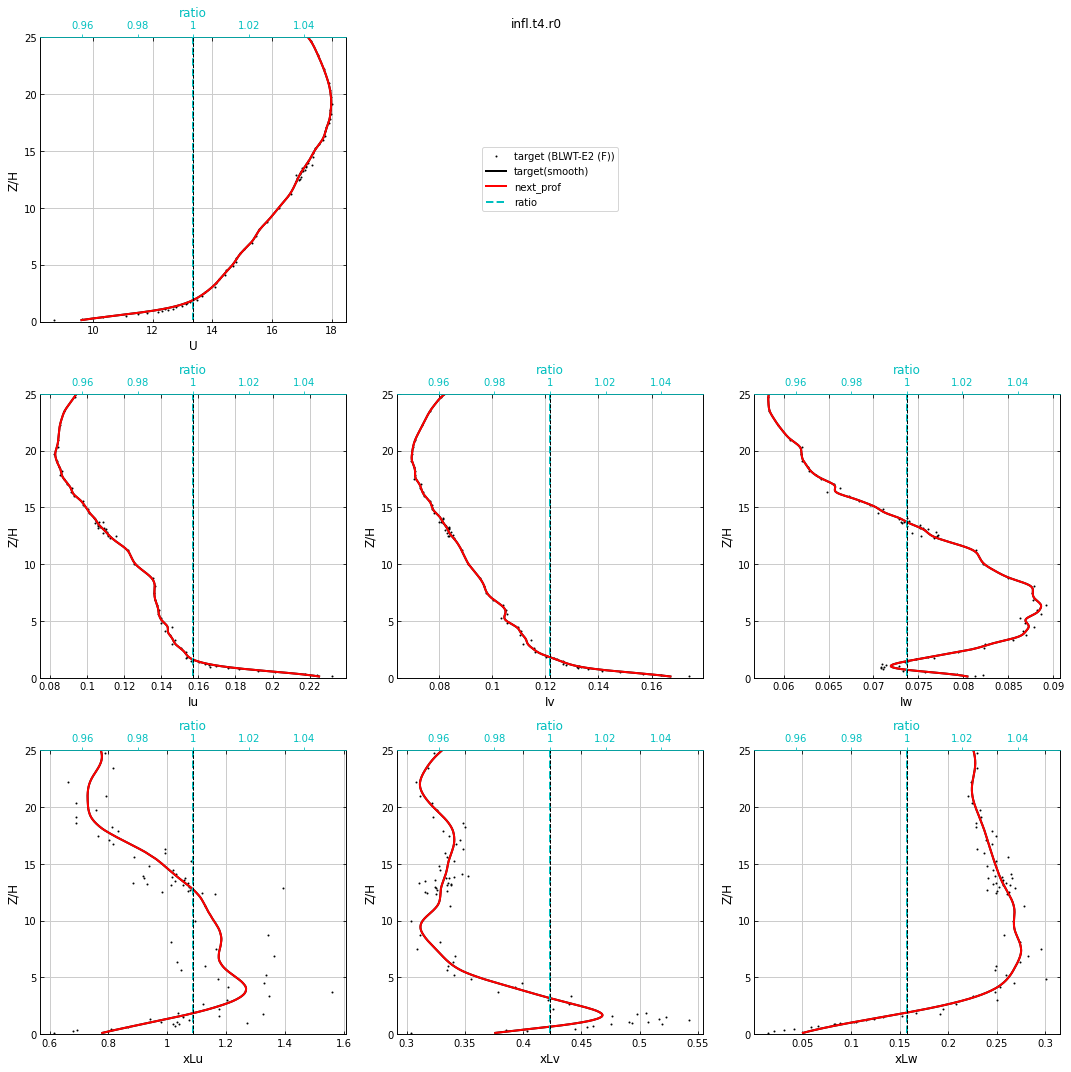

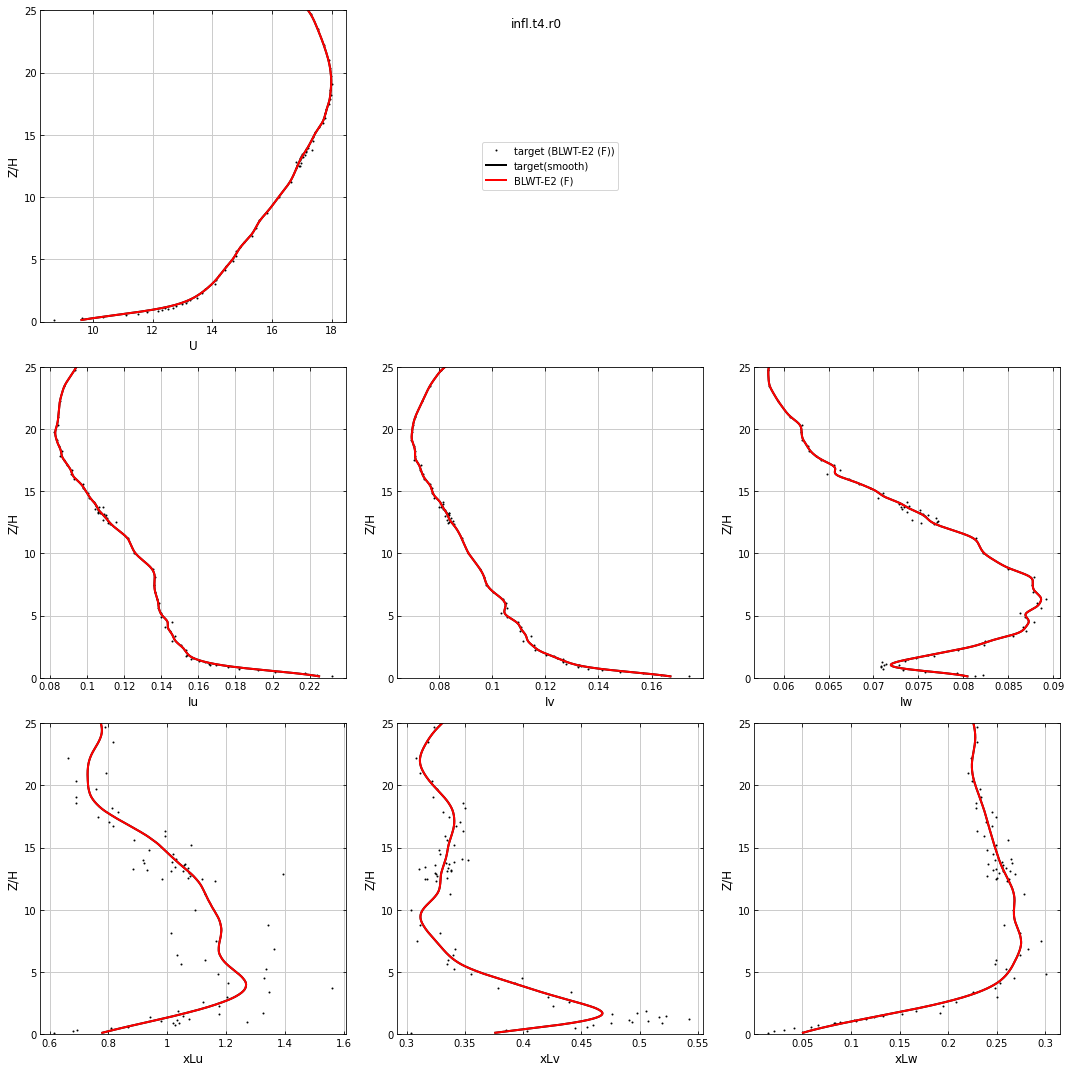

In [ ]:
rnd = 0
caseName = f'infl.t4.r{rnd}'
prof = infl_E2_trial4.writeProfile(
                            dir=trial_dir_in + f'/{caseName}/',
                            caseName=caseName,
                            description='Round 0: start from scratch with wider domain and uniform mesh up to 5H.',
                            rounds=rnd,
                            figsize=[15,15],
                            zLim=[0,25],
                            debugMode=True,
                            compensateFor_xLi_in_Ii=False,
                            zMin_scaling=0.06,
                            zMax_scaling=0.08*25,
                                               # round: [1,      2,      3,      4,     5,      6,]
                            scaleByFixedRefHeightRatio= [False,  False,  True,   False, False,  False,],
                            scale_xLi=                  [False,  False,  False,  False, False,  False,],
                            smoothRatios=               [True,   True,   True,   True,  True,   True,],
                            smoothTheTarget=True,
                            smoothWindow_ratios=[60, 100, 100, 100, 200, 150, 200],
                            smoothWindow_target=[80, 50, 50, 50, 200, 150, 200],
                            applyLimitedSmoothing=False,
                            kwargs_smooth={'window':'hamming', 'mode':'valid', 'usePadding':True, 'paddingFactor':2, 'paddingMode':'edge'},
                            )

# Plot a trial set

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2950: RuntimeWarning: invalid value encountered in log
  


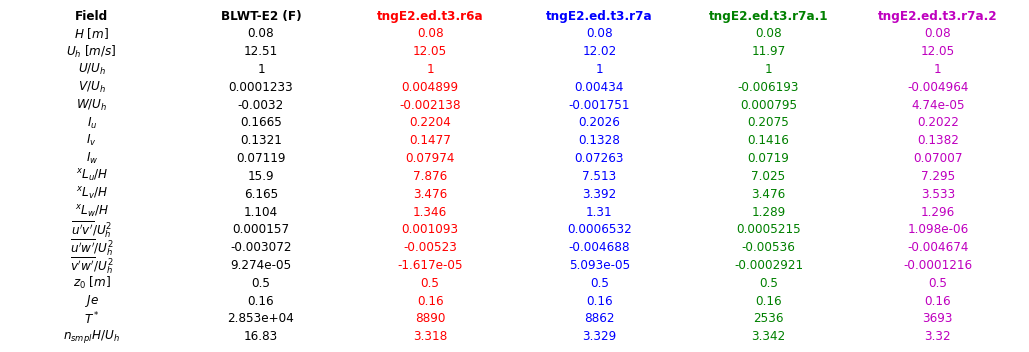

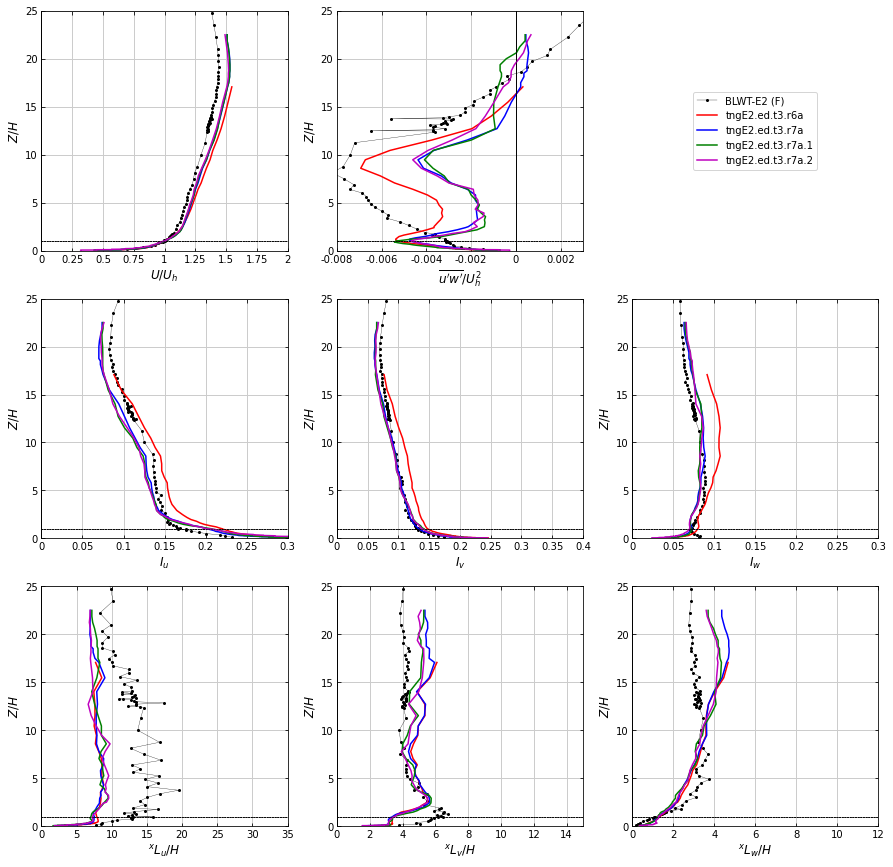

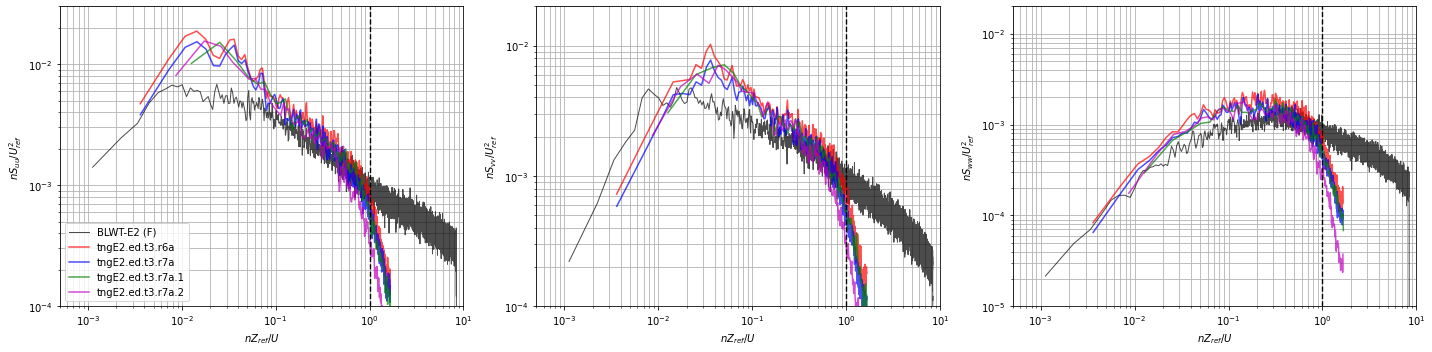

In [13]:
(fig,_), (table,_) = infl_E2_trial3.plotProfiles(figsize=[15,15], 
                        zLim=[0,25], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,15], xLimits_xLw=[0,12], 
                        includeInflows=False, includeIncidents=True, includeRefProfiles=False,
                        normalize=True,
                        ms=4, lw=1.5,
                        )
# fig.savefig(trial_dir_ed+'/profiles.svg', dpi=300, bbox_inches='tight')
# table.savefig(trial_dir_ed+'/profiles_table.svg', dpi=300, bbox_inches='tight')

fig = infl_E2_trial3.plotSpectra(figSize=[20,5],
                    includeInflows=False, includeIncidents=True, includeRefProfiles=False, 
                    yLimits=[[1e-4,0.03],[1e-4,0.02],[1e-5,0.02]],
                    xLimits=[5e-4,1e1],
                    kwargs_pltSpectra={'normalize':True},
                    )
# fig.savefig(trial_dir_ed+'/spectra.svg', dpi=300, bbox_inches='tight')


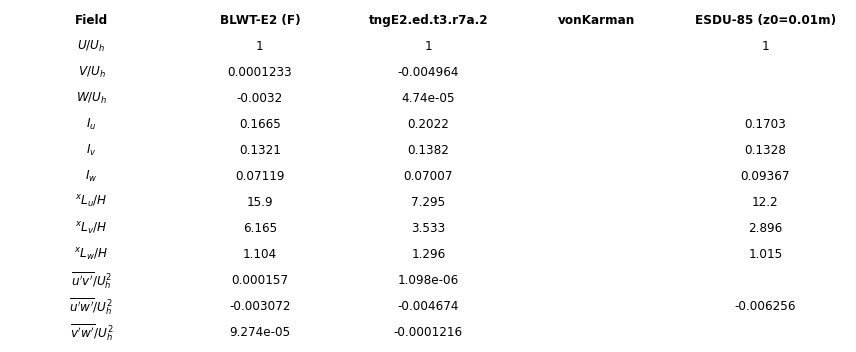

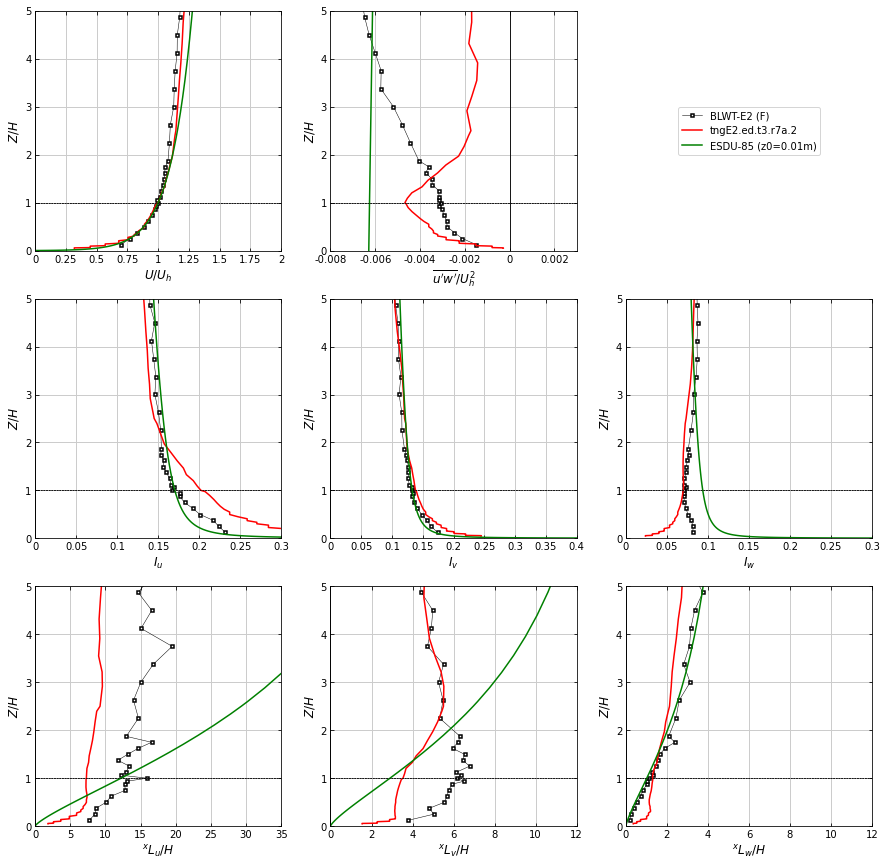

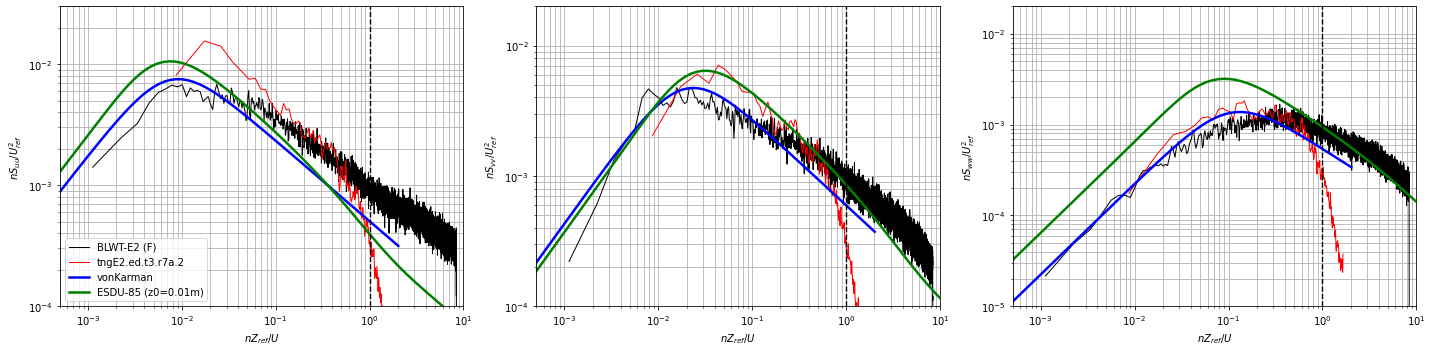

In [14]:
prf = wind.Profiles([infl_E2_trial3.target, infl_E2_trial3.incidents[-1],infl_E2_trial3.refProfiles[-1], infl_E2_trial3.refProfiles[-2]])
_ = prf.plotRefHeightStatsTable(fontSz=12)
_ = prf.plotProfile_basic2(figsize=[15,15],
                        yLimits=[0,5],
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003],
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.3],
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12],
                        normalize=True,
                        kwargs_plt=[
                            {'color': 'k', 'linewidth':0.5, 'linestyle': '-',    'marker': 's', 'markersize':3, 'markerfacecolor':'w', 'markeredgewidth':1.5},
                            {'color': 'r', 'linewidth':1.5, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            {'color': 'b', 'linewidth':1.5, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            {'color': 'g', 'linewidth':1.5, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            ],
                        )
_ = prf.plotSpectra(figsize=[20,5], 
                yLimits=[[1e-4,0.03],[1e-4,0.02],[1e-5,0.02]],
                xLimits=[5e-4,1e1],
                kwargs_plt=[
                            {'color': 'k', 'linewidth':1, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            {'color': 'r', 'linewidth':1, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            {'color': 'b', 'linewidth':2.5, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            {'color': 'g', 'linewidth':2.5, 'linestyle': '-',    'marker': 'None', 'markersize':4, 'markerfacecolor':'w'},
                            ],
                        )

(23.5, 40.0)

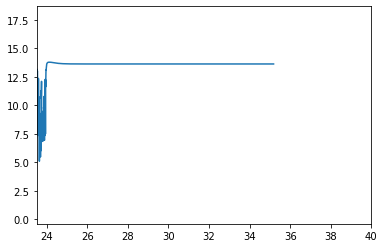

In [36]:
p = infl_E2_trial3.incidents[-1]

plt.plot(p.t, p.UofT[10,:])
plt.xlim(23.5, 40)

# Quick tests

In [ ]:
inflowDir_E2_test = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/tngE2.infl/"

infl_quick = foam.inflowTuner(H=H, nSpectAvg=32, target=wtVel_E2,)

trial_dir_in = inflowDir_E2+'tuning.trial3/'

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0')
# infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0', name='DFSR.r0')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed1')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed1', name='DFSR.r0.seed1')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed2')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed2', name='DFSR.r0.seed2')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0_seed3')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0_seed3', name='DFSR.r0.seed3')

# # convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r1')
# infl_seed.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r1', name='DFSR.r1')


# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0.n200')
# infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0.n200', name='DFSR.r0.n200')

name = 'infl.t3.r1'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_quick.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

name = 'infl.t3.r1_qchk_C3'
convertDFSR_out_toNPY(trial_dir_in, name)
infl_quick.addInflow(caseName=trial_dir_in, sampleName=name, name=name, nSpectAvg=48)

# convertDFSR_out_toNPY(inflowDir_E2+'tuning/', 'infl.r0.n25m4096')
# infl_quick.addInflow(caseName=inflowDir_E2+'tuning/', sampleName='infl.r0.n25m4096', name='DFSR.r0.n25m4096')

n=np.logspace(-3.5,2.5,100)
infl_quick.refProfiles = wind.Profiles([wind.ESDU74(z0=0.01).toProfileObj(n=n), ])

In [ ]:
_ = infl_quick.plotProfiles(figsize=[15,15], 
                        zLim=[0,5], 
                        xLimits_U=[0, 2], xLimits_uw=[-0.008, 0.003], 
                        xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
                        xLimits_xLu=[0, 35], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
                        includeInflows=True, includeIncidents=False, normalize=True,
                        ms=4, lw=1.5)
_ = infl_quick.plotSpectra(figSize=[20,6],
                    includeInflows=True, includeIncidents=False,
                    yLimits=[[1e-7,2e-2],[1e-5,2e-2],[1e-6,2e-2]],)

In [ ]:
prof = foam.readVelProfile(caseDir=r'D:/tempData_depot/simData_FFS/FFS_ABL_inf/',
                           probeName=r'probes.zProfile.x0.0',
                           name='FFS_ABL_inf', 
                           showLog=True, 
                           trimTimeSegs=[[0,0.1],],
                           H=0.08)
profs = wind.Profiles([wtVel_E2, prof,])
profs.plotProfile_basic2(yLimits=[0,12])
profs.plotSpectra(figSize=[20,6],)